# MAF analysis
Notebook to analyse the v2.0 and v2.1 simulations, as well as compare the v1.5 MAF metrics vs. the original DESC metrics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy

%matplotlib widget

## File storage
This is where all the inputs and outputs go. I've provided `metrics_v1_5.csv` because this was run internally. The other files, `summary_2022_04_28.csv` and `all_summaries_2021_04_07_v1_5-1_7.csv` must be downloaded separately from https://github.com/lsst-pst/survey_strategy/tree/main/fbs_2.0 and https://github.com/lsst-pst/survey_strategy/tree/main/fbs_1.7 respectively.

In [2]:
analysis_dir = 'FBS_analysis/' 

## Select metrics to plot
We need to select which metrics we want to plot and provide shorter display names. In order to convert the metrics correctly for comparison, we need to know if any transforms need to be applied. Possibilities include: <br>

invert = $1/x$ <br>
convert_to_flux = $10^{(-x/2.5)}$ <br>
convert_to_precision = $1/x^2$ <br>
one_minus = $1-2x$

In [3]:
metric_names = pd.DataFrame(None, columns=['v2_0_name', 
                                           'display_name', 
                                           'v1_5_name',
                                           'original_name',
                                           'invert', 
                                           'convert_to_flux', 
                                           'convert_to_precision', 
                                           'one_minus'])

In [4]:
metric_names

,v2_0_name,display_name,v1_5_name,original_name,invert,convert_to_flux,convert_to_precision,one_minus


### Static science FoM

In [5]:
metric_names.loc['fom'] =  ['3x2ptFoM ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer',
                           'WL + LSS DETF Figure of Merit',
                           '3x2ptFoM ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer',
                           'wl_fom',
                           False, False, False, False]

### Weak lensing systematics

In [6]:
metric_names.loc['wl'] = ['Median WeakLensingNvisits gri band non-DD HealpixSlicer',
                          'WL average visits',
                          'Mean WeakLensingNvisits fiveSigmaDepth, visitExposureTime i band non-DD HealpixSlicer',
                          'wl_systematics',
                          False, False, False, False]

### Strong lensing

In [7]:
metric_names.loc['sl'] = ['Total detected SNSLMetric  HealpixSlicer',
                          'Number of SNe Ia lensed by galaxies', 
                          'N_lenses TDC  HealpixSlicer',
                          'sl_num_lensed_SNe_Ia_with_good_time_delays_lensed_by_galaxies',
                          False, False, False, False]

### Supernovae

In [8]:
metric_names.loc['sn'] = ['Total detected SNNSNMetric_nSN  HealpixSlicer',
                          'Number of SNe Ia with z<zlim(med)',
                          'SNIa_WellSampled non-DD UserPointsSlicer',
                          'sn_normal_nsn_tot',
                          False, False, False, False]

### Kilonovae

In [9]:
metric_names.loc['kn'] = ['Total detected KNePopMetric_all__multi_color_detect all models UserPointsSlicer',
                          'kN Population Counts 10yrs',
                          'KN_Detected  UserPointsSlicer',
                          'kn_Maf_Mean_Counts',
                          False, False, False, False]

### Effective Area

In [10]:
metric_names.loc['area'] = ['Effective Area (deg) ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer',
                          'Y10 area for static science (deg$^2$)',
                          'Effective Area (deg) ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer',
                          'static_Y10 effective survey area',
                          False, False, False, False]

## Load the MAF summary file
This is the file output by the simulation team when new versions of observing strategy simulations are run. It's a giant csv file with a large range of metrics, including some contributed by DESC.

Summary of the simulations: https://github.com/lsst-pst/survey_strategy/blob/main/fbs_2.0/SummaryInfo_v2.1.ipynb

In [11]:
maf_output_summary_file = analysis_dir + 'summary_2022_06_22_v2_0.txt'
maf_output_full_v2 = pd.read_csv(maf_output_summary_file, index_col=0)

In [41]:
maf_columns = []
for idx in metric_names.index:
    maf_columns.append(metric_names.loc[idx, 'v2_0_name'])

In [42]:
maf_output = maf_output_full_v2[maf_columns]

In [43]:
# Load the v1.5 results. I couldn't get them from MAF

In [44]:
baseline = 'baseline_v2.0_10yrs'

## Compute the metrics relative to baseline
We always compare metrics by subtracting their value at baseline, and then dividing by their value at baseline. So all metrics can be considered as percentage improvement or degradation.

In [45]:
def compute_relative_improvement(metric_series, 
                                 baseline, 
                                 invert=False,
                                 convert_to_flux=False,
                                 convert_to_precision=False,
                                 one_minus=False):
    """
    Calculates the improvement of the metric over the given baseline, including applying the appropriate 
    transforms. Transforms are applied in the same order as used in Lochner et al. so for instance, a value
    will first be converted to flux and then to precision.
    """
    if convert_to_flux:
        metric_series = 10**(-metric_series/2.5)

    if one_minus:
        metric_series = 1 - 2*metric_series

    if invert:
        metric_series = 1/metric_series

    if convert_to_precision:
        metric_series = 1/metric_series**2
        
    baseline_value = metric_series.loc[baseline]
    
    return (metric_series - baseline_value)/baseline_value   

In [46]:
maf_output_rel = maf_output.copy()
for idx in metric_names.index:
    metric = metric_names.loc[idx, 'v2_0_name']
    rel_series = compute_relative_improvement(maf_output[metric], 
                                 baseline,
                                 metric_names.loc[idx, 'invert'], 
                                 metric_names.loc[idx, 'convert_to_flux'],
                                 metric_names.loc[idx, 'convert_to_precision'],
                                 metric_names.loc[idx, 'one_minus'])
    maf_output_rel[metric] = rel_series

## Read in the results from v1.5 so we can compare against Lochner et al. 2022

In [47]:
metrics_v1_5_full = pd.read_csv(analysis_dir + 'metrics_v1_5.csv', index_col=0)
v1_5_columns = []
for idx in metric_names.index:
    v1_5_columns.append(metric_names.loc[idx, 'original_name'])
metrics_v1_5 = metrics_v1_5_full[v1_5_columns]

In [48]:
metrics_v1_5_rel = metrics_v1_5.copy()
for idx in metric_names.index:
    original_name = metric_names.loc[idx, 'original_name']
    rel_series = compute_relative_improvement(metrics_v1_5_rel[original_name], 
                                 'baseline_v1.5_10yrs',
                                 metric_names.loc[idx, 'invert'], 
                                 metric_names.loc[idx, 'convert_to_flux'],
                                 metric_names.loc[idx, 'convert_to_precision'],
                                 metric_names.loc[idx, 'one_minus'])
    metrics_v1_5_rel[original_name] = rel_series

In [49]:
summary_v1_5 = pd.DataFrame(None, columns=metrics_v1_5_rel.columns)
summary_v1_5.loc['mean'] = metrics_v1_5_rel.mean()
summary_v1_5.loc['min'] = metrics_v1_5_rel.min()
summary_v1_5.loc['max'] = metrics_v1_5_rel.max()
summary_v1_5

,wl_fom,wl_systematics,sl_num_lensed_SNe_Ia_with_good_time_delays_lensed_by_galaxies,sn_normal_nsn_tot,static_Y10 effective survey area,kn_Maf_Mean_Counts
mean,0.011789,-0.014386,-0.079523,-0.013419,0.013850,-0.016499
min,-0.228327,-0.192424,-1.000000,-0.361539,-0.459996,-0.300625
max,0.157141,0.705836,0.169283,0.407864,0.157356,0.513114


In [50]:
summary_v2_0 = pd.DataFrame(None, columns=maf_output_rel.columns)
summary_v2_0.loc['mean'] = maf_output_rel.mean()
summary_v2_0.loc['min'] = maf_output_rel.min()
summary_v2_0.loc['max'] = maf_output_rel.max()
summary_v2_0

,3x2ptFoM ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer,Median WeakLensingNvisits gri band non-DD HealpixSlicer,Total detected SNSLMetric HealpixSlicer,Total detected SNNSNMetric_nSN HealpixSlicer,Effective Area (deg) ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer,Total detected KNePopMetric_all__multi_color_detect all models UserPointsSlicer
mean,-0.011164,-0.019532,0.016646,-0.084165,-0.012746,-0.032236
min,-0.288413,-0.227991,-0.306039,-0.752574,-0.302345,-0.383538
max,0.055626,0.343115,0.287459,0.096411,0.033198,0.147694


## Save to csv

In [51]:
maf_output_rel.to_csv(analysis_dir + 'maf_v2_rel.csv')
maf_output.to_csv(analysis_dir + 'maf_v2.csv')
# metrics_v1_5.to_csv(analysis_dir + 'metrics_v1_5.csv')
metrics_v1_5_rel.to_csv(analysis_dir + 'metrics_v1_5_rel.csv')
summary_v1_5.to_csv(analysis_dir + 'summary_v1_5.csv')
summary_v2_0.to_csv(analysis_dir + 'summary_v2.csv')

## Check the v1.5 metrics
This is a sanity check I did to see if the MAF metrics being run as part of the bundle match our original metrics. This is pretty tricky since the names change between v1.5 and v2.0 and in some cases may not be the same metric.

In [52]:
maf_output_v1_5 = pd.read_csv(analysis_dir + 'all_summaries_2021_04_07_v1_5-1_7.csv', index_col=0)

/tmp/ipykernel_8012/3626169400.py:1: DtypeWarning: Columns (5942) have mixed types. Specify dtype option on import or set low_memory=False.
  maf_output_v1_5 = pd.read_csv(analysis_dir + 'all_summaries_2021_04_07_v1_5-1_7.csv', index_col=0)


In [53]:
metric_names

,v2_0_name,display_name,v1_5_name,original_name,invert,convert_to_flux,convert_to_precision,one_minus
fom,3x2ptFoM ExgalM5_with_cuts i band non-DD year ...,WL + LSS DETF Figure of Merit,3x2ptFoM ExgalM5_with_cuts i band non-DD year ...,wl_fom,False,False,False,False
wl,Median WeakLensingNvisits gri band non-DD Heal...,WL average visits,"Mean WeakLensingNvisits fiveSigmaDepth, visitE...",wl_systematics,False,False,False,False
sl,Total detected SNSLMetric HealpixSlicer,Number of SNe Ia lensed by galaxies,N_lenses TDC HealpixSlicer,sl_num_lensed_SNe_Ia_with_good_time_delays_len...,False,False,False,False
sn,Total detected SNNSNMetric_nSN HealpixSlicer,Number of SNe Ia with z<zlim(med),SNIa_WellSampled non-DD UserPointsSlicer,sn_normal_nsn_tot,False,False,False,False
area,Effective Area (deg) ExgalM5_with_cuts i band ...,Y10 area for static science (deg$^2$),Effective Area (deg) ExgalM5_with_cuts i band ...,static_Y10 effective survey area,False,False,False,False
kn,Total detected KNePopMetric_all__multi_color_d...,kN Population Counts 10yrs,KN_Detected UserPointsSlicer,kn_Maf_Mean_Counts,False,False,False,False


In [54]:
# for c in maf_output_v1_5.columns:
#     if 'Inter' in c:
#         print(c)

In [55]:
inds = []
for idx in metrics_v1_5.index:
    if idx in maf_output_v1_5.index:
        inds.append(idx)

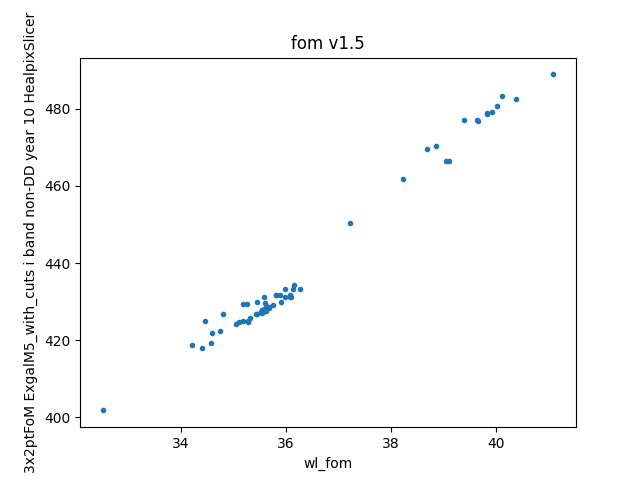

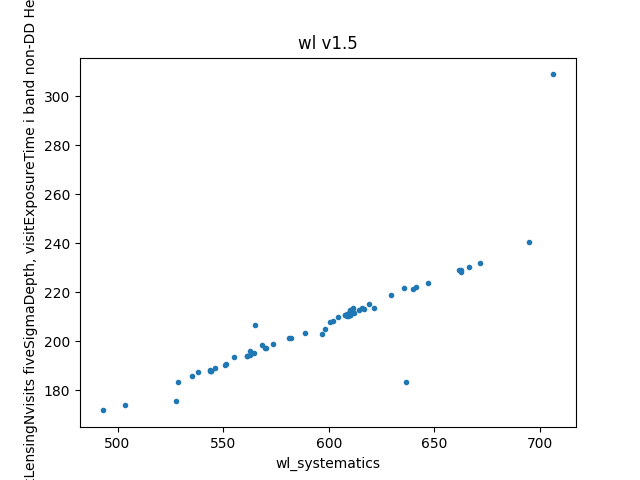

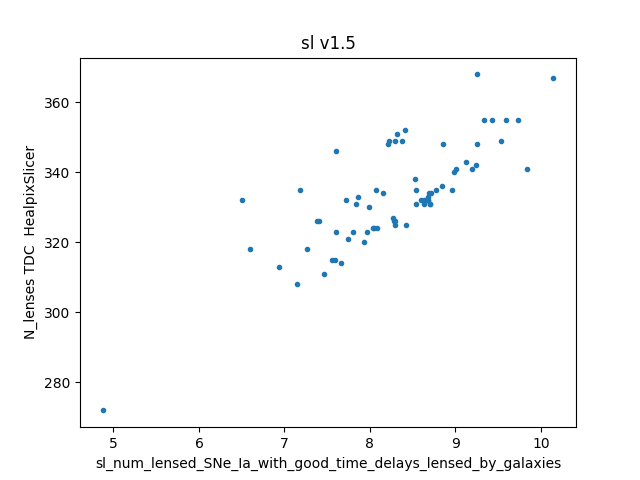

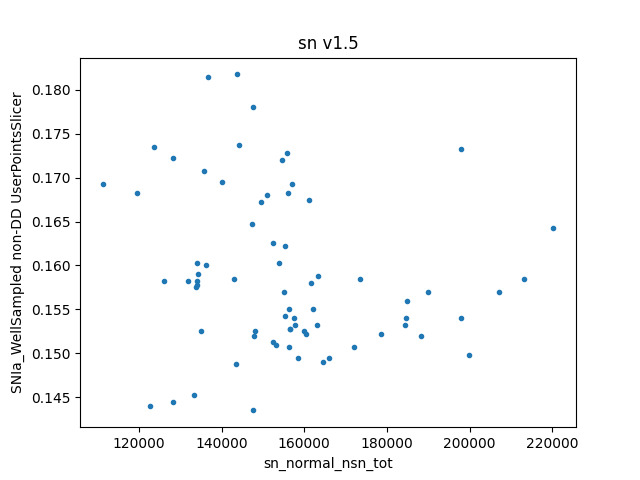

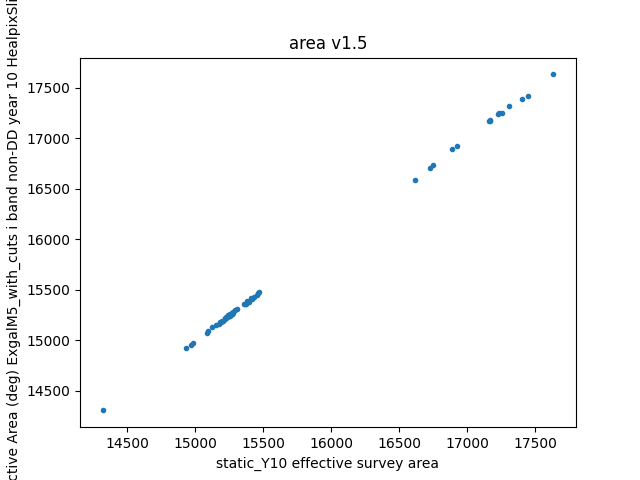

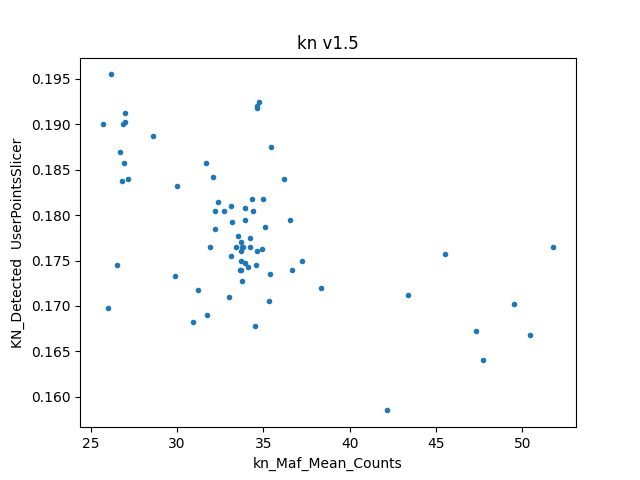

In [56]:
for idx in metric_names.index:
    if metric_names.loc[idx, 'v1_5_name'] != '':
        plt.figure()
        original_name = metric_names.loc[idx, 'original_name']
        maf_name = metric_names.loc[idx, 'v1_5_name']
        plt.plot(metrics_v1_5.loc[inds, original_name], maf_output_v1_5.loc[inds, maf_name], '.')
        plt.xlabel(original_name)
        plt.ylabel(maf_name)
        plt.title(idx + ' v1.5')
        plt.savefig(f'{analysis_dir}figures/{idx}.png')

## Investigating the SN and KN metrics
It's tough to figure out what's going on with these metrics so we use Nvis as a proxy since we know SN correlate well with Nvis (less so for KN so it's harder to draw a conclusion there)

### SN: Number of visits vs. v1.5 MAF metric

Text(0, 0.5, 'SNIa_WellSampled non-DD UserPointsSlicer')

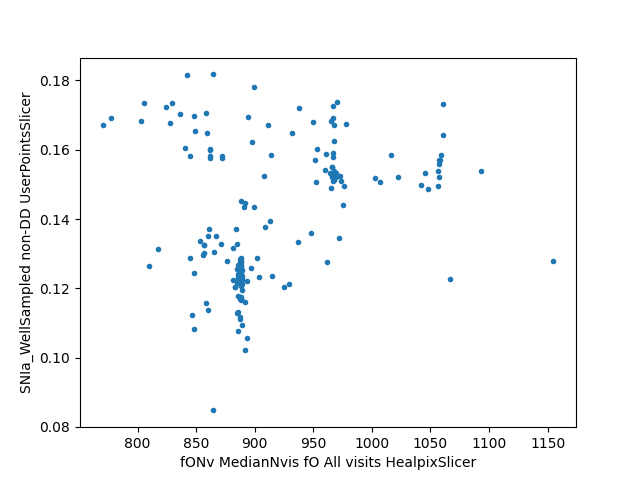

In [57]:
plt.figure()
nvis_name = 'fONv MedianNvis fO All visits HealpixSlicer'
sn_name = metric_names.loc['sn', 'v1_5_name']
plt.plot(maf_output_v1_5[nvis_name], maf_output_v1_5[sn_name],'.')
plt.xlabel(nvis_name)
plt.ylabel(sn_name)

### SN: Number of visits vs. OUR v1.5 metric

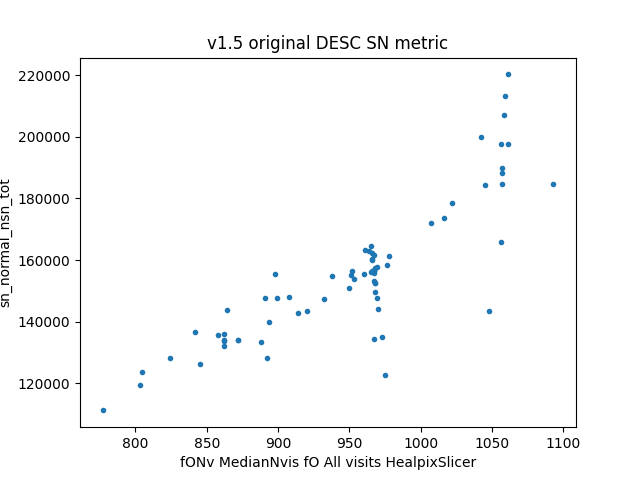

In [58]:
plt.figure()
nvis_name = 'fONv MedianNvis fO All visits HealpixSlicer'
sn_name = metric_names.loc['sn', 'original_name']
plt.plot(maf_output_v1_5.loc[inds, nvis_name], metrics_v1_5.loc[inds, sn_name],'.')
plt.xlabel(nvis_name)
plt.ylabel(sn_name)
plt.title('v1.5 original DESC SN metric')
plt.savefig(analysis_dir + 'figures/SN_original_v1_5.png')

### SN: Number of visits vs. v2.0 MAF metric

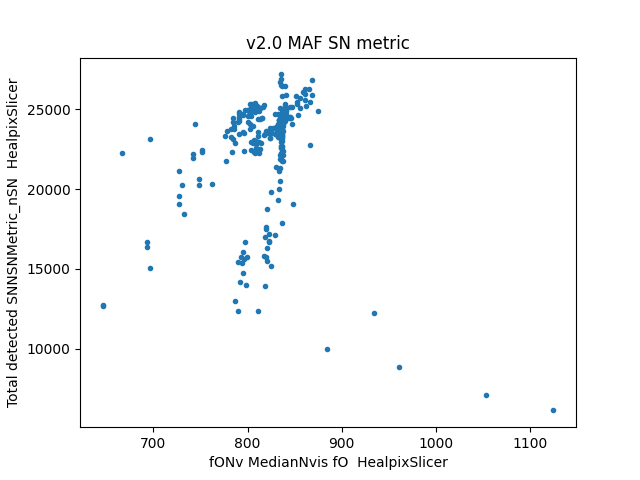

In [59]:
plt.figure()
nvis_name = 'fONv MedianNvis fO  HealpixSlicer'
sn_name = metric_names.loc['sn', 'v2_0_name']
plt.plot(maf_output_full_v2[nvis_name], maf_output_full_v2[sn_name],'.')
plt.xlabel(nvis_name)
plt.ylabel(sn_name)
plt.title('v2.0 MAF SN metric')
plt.savefig(analysis_dir + 'figures/SN_maf_v2_0.png')

### KN: Number of visits vs. v1.5 MAF metric

Text(0, 0.5, 'KN_Detected  UserPointsSlicer')

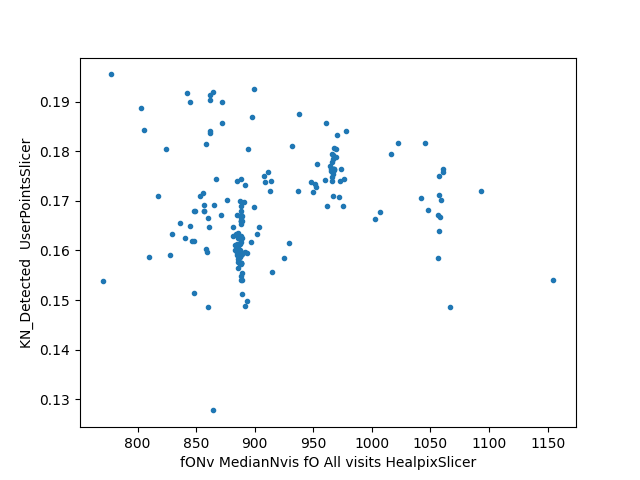

In [60]:
plt.figure()
nvis_name = 'fONv MedianNvis fO All visits HealpixSlicer'
kn_name = metric_names.loc['kn', 'v1_5_name']
plt.plot(maf_output_v1_5[nvis_name], maf_output_v1_5[kn_name],'.')
plt.xlabel(nvis_name)
plt.ylabel(kn_name)

### KN: Number of visits vs. OUR v1.5 metric

Text(0.5, 1.0, 'v1.5 original DESC KN metric')

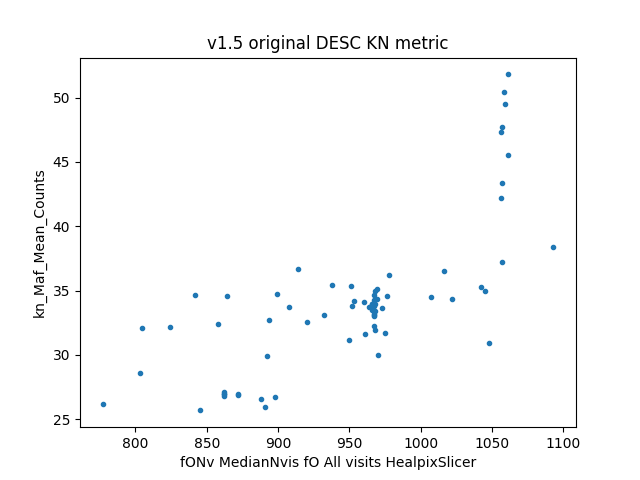

In [61]:
plt.figure()
nvis_name = 'fONv MedianNvis fO All visits HealpixSlicer'
kn_name = metric_names.loc['kn', 'original_name']
plt.plot(maf_output_v1_5.loc[inds, nvis_name], metrics_v1_5.loc[inds, kn_name],'.')
plt.xlabel(nvis_name)
plt.ylabel(kn_name)
plt.title('v1.5 original DESC KN metric')

### KN: Number of visits vs. v2.0 MAF metric

/tmp/ipykernel_8012/3530414646.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Text(0.5, 1.0, 'v2.0 MAF KN metric')

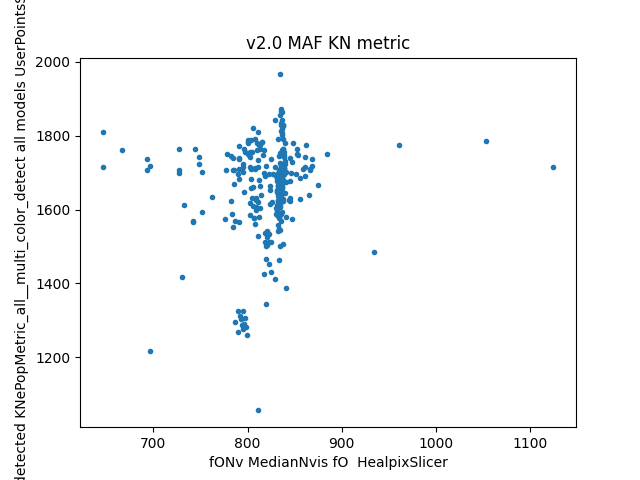

In [62]:
plt.figure()
nvis_name = 'fONv MedianNvis fO  HealpixSlicer'
kn_name = metric_names.loc['kn', 'v2_0_name']
plt.plot(maf_output_full_v2[nvis_name], maf_output_full_v2[kn_name],'.')
plt.xlabel(nvis_name)
plt.ylabel(kn_name)
plt.title('v2.0 MAF KN metric')

### SLSN: Internight gap vs. our v1.5 metric

Text(0.5, 1.0, 'v1.5 original DESC SLSN metric')

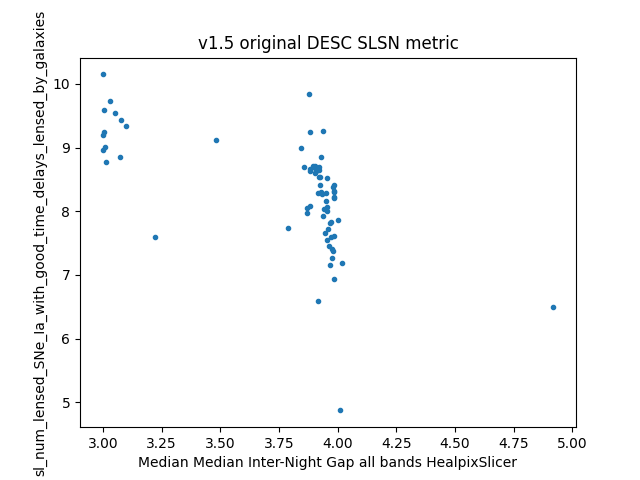

In [78]:
plt.figure()
prop_name = 'Median Median Inter-Night Gap all bands HealpixSlicer'
metric_name = metric_names.loc['sl', 'original_name']
plt.plot(maf_output_v1_5.loc[inds, prop_name], metrics_v1_5.loc[inds, metric_name],'.')
plt.xlabel(prop_name)
plt.ylabel(metric_name)
plt.title('v1.5 original DESC SLSN metric')

### SLSN: Internight gap vs. v2.0 MAF metric

Text(0.5, 1.0, 'v2.0 MAF SLSN metric')

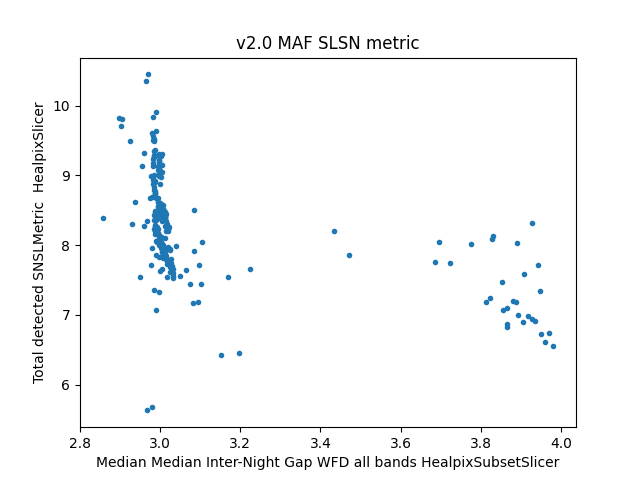

In [81]:
plt.figure()
prop_name = 'Median Median Inter-Night Gap WFD all bands HealpixSubsetSlicer'
metric_name = metric_names.loc['sl', 'v2_0_name']
plt.plot(maf_output_full_v2[prop_name], maf_output_full_v2[metric_name],'.')
plt.xlabel(prop_name)
plt.ylabel(metric_name)
plt.title('v2.0 MAF SLSN metric')

### KN: Internight gap vs. v2.0 MAF metric

Text(0.5, 1.0, 'v2.0 MAF KN metric')

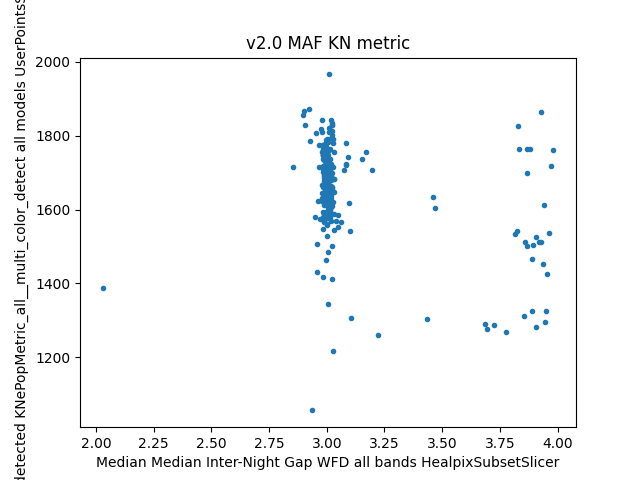

In [82]:
plt.figure()
prop_name = 'Median Median Inter-Night Gap WFD all bands HealpixSubsetSlicer'
metric_name = metric_names.loc['kn', 'v2_0_name']
plt.plot(maf_output_full_v2[prop_name], maf_output_full_v2[metric_name],'.')
plt.xlabel(prop_name)
plt.ylabel(metric_name)
plt.title('v2.0 MAF KN metric')

## Check the cumulative season length

Text(0, 0.5, 'Mean Median Season Length WFD r band HealpixSlicer')

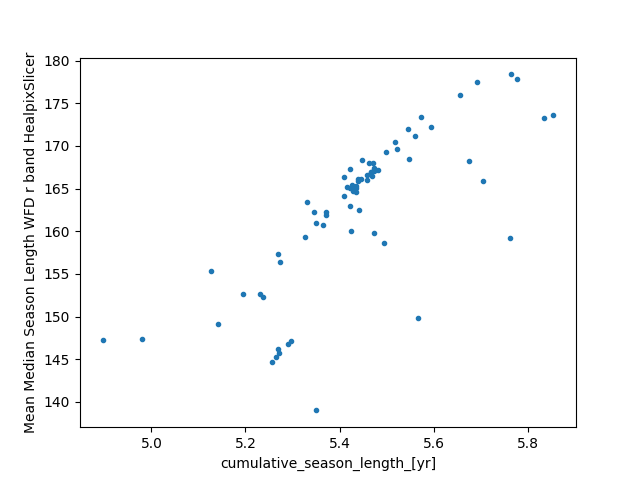

In [37]:
plt.figure()
maf_name = 'Mean Median Season Length WFD r band HealpixSlicer'
# maf_name = 'Mean TDC_Season  HealpixSlicer'
desc_metric_name = 'cumulative_season_length_[yr]'
plt.plot(metrics_v1_5_full.loc[inds, desc_metric_name],
         maf_output_v1_5.loc[inds, maf_name], '.')
plt.xlabel(desc_metric_name)
plt.ylabel(maf_name)